### Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth **MSA**).

**MSA** methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)

We will use the files of FASTA format (*curated_uniprot.fasta_*) with the information of hsp regions and the amino acid sequences.

In [164]:
import argparse
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from os import path
import sys
import json
import os
import subprocess
from Bio.Blast import NCBIXML
import ipywidgets as widgets

In [80]:
# Check the current directory for assigning the variable for the functions below
print('Get current working directory:', os.getcwd())

Get current working directory: /Users/alina/HMMER


In [4]:
directory = "/Users/alina/HMMER"

Here, we have defined a function that can parse a fasta file into a pandas dataframe. This function can be used to add any additional column containing information about hsp.

In [165]:
# Parse the fasta file to create a pandas dataframe
input_files = ['{}/curated_uniprot.fasta_75'.format(directory)]
dfs = []
max_query_length = 0

for input_file in input_files:
    with open(input_file) as f:
        blast_records = NCBIXML.parse(f)
        data = []

        # Iterate PSIBLAST rounds
        for blast_record in blast_records:
            query_id = blast_record.query

            # Get the length of the query sequence
            query_length = int(blast_record.query_letters)
            if query_length > max_query_length:
                max_query_length = query_length

            # Iterate alignments (here just one)
            for i, alignment in enumerate(blast_record.alignments):
                subject_id = alignment.title

                # Iterate pairwise alignments
                for hsp in alignment.hsps:
                    data.append((query_id.split(" ")[0],
                                    subject_id.split(" ")[0],
                                    query_length,
                                    hsp.align_length,
                                    hsp.query,
                                    hsp.match,
                                    hsp.sbjct,
                                    hsp.query_start,
                                    hsp.query_end,
                                    hsp.sbjct_start,
                                    hsp.sbjct_end,
                                    hsp.identities,
                                    hsp.positives,
                                    hsp.gaps,
                                    hsp.expect,
                                    hsp.score,
                                    ))

                    # Skip duplicated subjects
                    break

        dfs.append(pd.DataFrame(data, columns=["query_id", "subject_id", "query_len", "hsp_len", "query_seq",
                                               "match_seq", "subject_seq", "query_start", "query_end",
                                               "subject_start", "subject_end", "identity", "positive",
                                               "gaps", "eval", "bit_score"]))

In [166]:
# Print the resulting dataframe with shortened query and subject ID
df = dfs[0]
df

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y5V3I1|A0A7Y5V3I1_9CHLR,391,387,LVIALLVVSLVVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVE...,LV LL V + +P L IW + L +L F ++GV VE...,LVFGLLAVPALAQDRPDLLIWADRTRTPPLTELATTFAEEFGVTVE...,5,390,14,397,141,220,4,7.015510e-82,695.0
8652,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A2M8NZZ8|A0A2M8NZZ8_9CHLR,391,405,FLVIALLVVSLVVL----AQPKLTIWCSEKQVDILQKLGEEFKAKY...,L++A++ +L VL L IW + + IL+ LG +FK ++...,LLIVAVMFGALGVLNVRAQDATLLIWADDTRAPILEALGAKFKEEF...,4,387,9,405,152,241,29,7.935620e-82,679.0
8653,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y2F1B7|A0A7Y2F1B7_9ACTN,391,368,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,L +W + + + + F+ GV +EVQ V+F DI+ + A...,SLLVWTDANRAPVFESIAPAFEEATGVNIEVQIVDFGDIREQVQVA...,21,387,71,436,133,208,3,1.031540e-81,681.0
8654,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A101IFE6|A0A101IFE6_9CHLR,391,372,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,+ IW E++ +L +L +F A+YGVE+ V+ N I+ +F A...,SIRIWADEQRAPVLSELATDFLAEYGVELVVE--NISGIRDQFSVA...,21,391,63,424,151,214,11,1.137790e-81,687.0


Then we create a dataframe with the 'query_id', 'subject_seq' and 'count' columns, representing the number of the unique combinations of the ids and sequences. We need to pay attention on each query id and summarize the data for all subject sequences occurred for that query, not the individual pair 'query-sequence'. For each query id we obtain the count of all subjects.

In [167]:
# Count the number of the unique combinations of 'query_seq' and 'subject_seq' columns
grouped = df.groupby(['query_id', 'subject_seq']).size().reset_index(name='count')

# Create a dataframe with the grouped counts of subject sequences' occurrence
grouped_counts = grouped.groupby('query_id')['subject_seq'].nunique().reset_index(name='count')
grouped_counts

,query_id,count
0,sp|Q16620|NTRK2_HUMAN,146
1,sp|Q3E829|CENPX_YEAST,144
2,sp|Q3YXW0|ZAPA_SHISS,14
3,sp|Q5T4W7|ARTN_HUMAN,188
4,sp|Q5VZK9|CARL1_HUMAN,196
5,sp|Q62141|SIN3B_MOUSE,179
6,sp|Q6F495|CURC2_MOLLA,186
7,sp|Q6TGC4|PADI6_HUMAN,191
8,sp|Q71SY5|MED25_HUMAN,171
9,sp|Q79V60|KAIC_THEVB,142


In [168]:
# Merge two dataframes: initial df and the grouped
merged = pd.merge(df, grouped_counts, on='query_id')
merged

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,146
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,146
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,146
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,146
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y5V3I1|A0A7Y5V3I1_9CHLR,391,387,LVIALLVVSLVVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVE...,LV LL V + +P L IW + L +L F ++GV VE...,LVFGLLAVPALAQDRPDLLIWADRTRTPPLTELATTFAEEFGVTVE...,5,390,14,397,141,220,4,7.015510e-82,695.0,185
8652,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A2M8NZZ8|A0A2M8NZZ8_9CHLR,391,405,FLVIALLVVSLVVL----AQPKLTIWCSEKQVDILQKLGEEFKAKY...,L++A++ +L VL L IW + + IL+ LG +FK ++...,LLIVAVMFGALGVLNVRAQDATLLIWADDTRAPILEALGAKFKEEF...,4,387,9,405,152,241,29,7.935620e-82,679.0,185
8653,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y2F1B7|A0A7Y2F1B7_9ACTN,391,368,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,L +W + + + + F+ GV +EVQ V+F DI+ + A...,SLLVWTDANRAPVFESIAPAFEEATGVNIEVQIVDFGDIREQVQVA...,21,387,71,436,133,208,3,1.031540e-81,681.0,185
8654,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A101IFE6|A0A101IFE6_9CHLR,391,372,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,+ IW E++ +L +L +F A+YGVE+ V+ N I+ +F A...,SIRIWADEQRAPVLSELATDFLAEYGVELVVE--NISGIRDQFSVA...,21,391,63,424,151,214,11,1.137790e-81,687.0,185


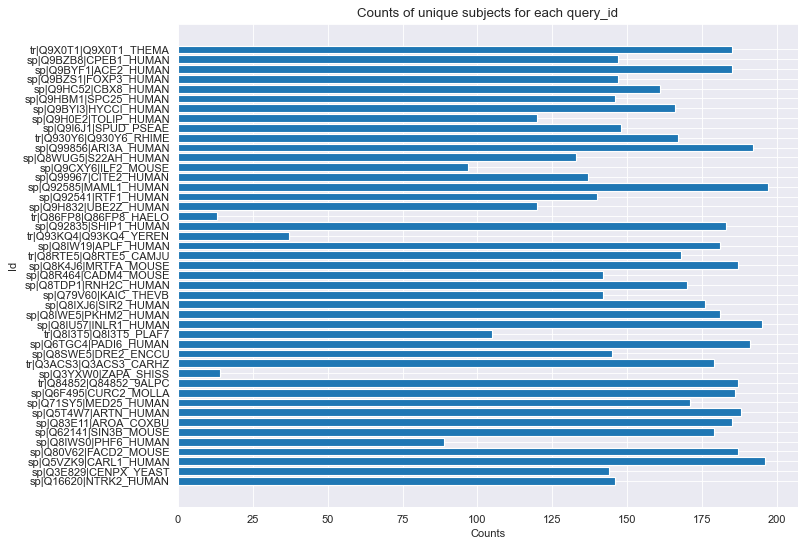

In [253]:
# Create a bar plot with the hits for each query ID
figure(figsize=(10, 8), dpi=80)
plt.barh(merged['query_id'], merged['count'])
plt.xlabel('Counts')
plt.ylabel('Id')
plt.title('Counts of unique subjects for each query_id')
plt.show()

Before we showed the overall proportion of unique subjects for query ids, but now we want to perform an analysis of each id separately.
We start with creating a dropdown list for query ids.

In [194]:
# Create a dropdown list of query ids (more than 1 can be chosen)
output = widgets.SelectMultiple(
    options=df["query_id"].unique(),
    rows=10,
    description='Query id',
    layout={'width': 'max-content'},
    disabled=False
)
display(output)

SelectMultiple(description='Query id', layout=Layout(width='max-content'), options=('sp|Q16620|NTRK2_HUMAN', '…

In [283]:
# Select query_id (1 or more) and filter merged df using these values
selected_id = output.value
selected = merged[merged["query_id"].isin(selected_id)]
selected

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
3369,sp|Q8IWE5|PKHM2_HUMAN,sp|Q8IWE5|PKHM2_HUMAN,1019,1019,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,1,1019,1,1019,1019,1019,0,0.0,5446.0,181
3370,sp|Q8IWE5|PKHM2_HUMAN,tr|A0A6D2X1H8|A0A6D2X1H8_PANTR,1019,1019,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,MEPGEVKDRILENISLSVKKLQSYFAACEDE PAIRNHDKVLQRLC...,MEPGEVKDRILENISLSVKKLQSYFAACEDETPAIRNHDKVLQRLC...,1,1019,1,1019,1013,1013,0,0.0,5408.0,181
3371,sp|Q8IWE5|PKHM2_HUMAN,tr|A0A2I3SLS9|A0A2I3SLS9_PANTR,1019,1019,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,MEPGEVKDRILENISLSVKKLQSYFAACEDE PAIRNHDKVLQRLC...,MEPGEVKDRILENISLSVKKLQSYFAACEDETPAIRNHDKVLQRLC...,1,1019,1,1019,1013,1013,0,0.0,5408.0,181
3372,sp|Q8IWE5|PKHM2_HUMAN,tr|A0A8D2G244|A0A8D2G244_THEGE,1019,1019,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,MEP EVKDRILENISLSVKKLQSYFAACEDE PAIRNHDKVLQRLC...,MEPREVKDRILENISLSVKKLQSYFAACEDETPAIRNHDKVLQRLC...,1,1019,1,1019,1012,1013,0,0.0,5404.0,181
3373,sp|Q8IWE5|PKHM2_HUMAN,tr|A0A2K5VKR3|A0A2K5VKR3_MACFA,1019,1019,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,MEP EVKDRILENISLSVKKLQSYFAACEDE PAIRNHDKVLQRLC...,MEPREVKDRILENISLSVKKLQSYFAACEDETPAIRNHDKVLQRLC...,1,1019,1,1019,1012,1013,0,0.0,5404.0,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3564,sp|Q8IWE5|PKHM2_HUMAN,tr|A0A8D0MIX1|A0A8D0MIX1_PIG,1019,1012,KKLQSYFAACEDEIPAIRNHDKVLQRLCEHLDHALLYGLQDLSSGY...,KKLQSYFAACEDE PAIRNHDKVLQRLCEHLDHALLYGLQDLSSGY...,KKLQSYFAACEDETPAIRNHDKVLQRLCEHLDHALLYGLQDLSSGY...,19,1019,19,1027,898,929,14,0.0,4571.0,181
3565,sp|Q8IWE5|PKHM2_HUMAN,tr|A0A2Y9Q926|A0A2Y9Q926_DELLE,1019,1028,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,MEP EVKDRILENISLSVKKLQSYFAACEDE PAIRNHDKVLQRLC...,MEPREVKDRILENISLSVKKLQSYFAACEDETPAIRNHDKVLQRLC...,1,1019,1,1004,902,924,33,0.0,4566.0,181
3566,sp|Q8IWE5|PKHM2_HUMAN,tr|A0A8C6B8S4|A0A8C6B8S4_MONMO,1019,1028,MEPGEVKDRILENISLSVKKLQSYFAACEDEIPAIRNHDKVLQRLC...,MEP EVKDRILENISLSVKKLQSYFAACEDE PAIRNHDKVLQRLC...,MEPREVKDRILENISLSVKKLQSYFAACEDETPAIRNHDKVLQRLC...,1,1019,1,1004,902,923,33,0.0,4565.0,181
3567,sp|Q8IWE5|PKHM2_HUMAN,tr|A0A8D0KJW4|A0A8D0KJW4_PIG,1019,1010,LQSYFAACEDEIPAIRNHDKVLQRLCEHLDHALLYGLQDLSSGYWV...,LQSYFAACEDE PAIRNHDKVLQRLCEHLDHALLYGLQDLSSGYWV...,LQSYFAACEDETPAIRNHDKVLQRLCEHLDHALLYGLQDLSSGYWV...,21,1019,21,1027,896,928,14,0.0,4563.0,181


Text(0.5, 1.0, 'HSP hits for the query id')

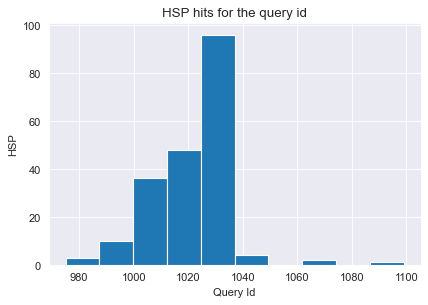

In [285]:
# Create a bar plot for the hits for the selected query sequence
figure(figsize=(6, 4), dpi=80)
plt.hist(selected['hsp_len'])
plt.xlabel('Query Id')
plt.ylabel('HSP')
plt.title('HSP hits for the query id')

In [34]:
# Create a hits_matrix 

hits_matrix = merged.groupby('query_seq')['subject_seq'].nunique().reset_index()
hits_matrix

,query_seq,subject_seq
0,AAAAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDT...,1
1,AAAAAGGAGGPGSGLAP-LPGLPPSAAAHGAALLSHWDPTLSSDWD...,1
2,AAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDTED...,1
3,AAAAGGAG-GPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDG...,1
4,AAAAGGAGGPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDGE...,1
...,...,...
2847,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2848,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2849,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2850,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1


In [214]:
# pivot the hits_matrix to create a matrix of counts
#matrix_of_counts = hits_matrix.pivot_table(index='query_seq', values='subject_seq', aggfunc='count')
matrix_of_counts = hits_matrix.pivot_table(index='query_seq', columns='subject_seq', values='count')
#matrix_of_counts = hits_matrix.pivot_table(index='query_seq', columns='subject_seq', values='count')
matrix_of_counts

KeyError: 'count'

<AxesSubplot:xlabel='query_seq', ylabel='query_seq'>

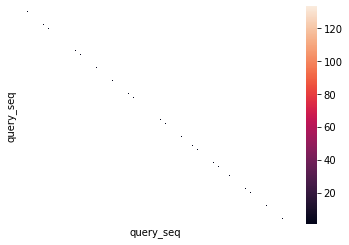

In [206]:
# Plot a heatmap

sns.heatmap(matrix_of_counts, xticklabels=False, yticklabels=False)

In [ ]:
# matrix N query_seq (rows): 2852, M subject_seq (columns): 6855

df['subject_seq'].nunique()

In [ ]:
# Generate the MSA

out_files = ["{}/output.fasta".format(directory)]

for df, out_file in zip(dfs, out_files):
    with open(out_file, "w") as fout:
        for index, row in df.iterrows():
            mapped_seq = ["-"] * max_query_length # Empty list of length = maximum query length
            c = 0
            if row["eval"] < 0.01:
                with open(out_file, "a") as fout: # append the output.fasta
                    for l_q, l_s in zip(row["query_seq"], row["subject_seq"]):
                        if l_q != " " and l_q != "-": # the element in query sequence
                            # avoid 'IndexError: list assignment index out of range'
                            if 1 <= row["query_start"] + c <= max_query_length:
                                mapped_seq[row["query_start"] + c - 1] = l_s if l_s != " " else "-"
                            c += 1
                    fout.write(">{}\n{}\n".format(row["subject_id"], "".join(mapped_seq)))